In [1]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from os.path import join
import efficientnet.tfkeras as efn
import pandas as pd

In [2]:
model_name = 'effNetTest'
model_path = join('output',model_name,'model.json')
weights_path = join('output',model_name,'model_weights.h5')
csv_path = 'data/test_pathology.csv'
augment_on_predict = True

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
def prepare_model(model_path,weights_path):
    with open(model_path,'r') as f:
        json_config = f.read()
        model = tf.keras.models.model_from_json(json_config)
        model.load_weights(weights_path)
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
        return model

In [5]:
#подгружаем модель

model = prepare_model(model_path,weights_path)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 192, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 96, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 96, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 96, 32)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [7]:
def get_data(path):
    
    df = pd.read_csv(path)
    paths = df.pop('path')
    
    paths = [str(elem) for elem in paths]
    y = df.to_numpy().astype('float32')
     
    category_names = df.columns.to_numpy()
    
    return np.array(paths),y,category_names

In [8]:
#подгружаем данные
x,y,category_names = get_data(csv_path)

In [9]:
#определяем количество классов

nb_classes = y.shape[1]

In [10]:
#создаем датагенератор

from DataGenerator import DataGenerator

gen = DataGenerator(x,y,batch_size=1,shuffle=False,augment = augment_on_predict)

In [11]:
#функция предикта
#количество итераций - сколько раз будет делаться предикт, после этого беретсся среднее
#
def get_predict(model,dataset,iterations = 3):
    
    y_predictions = []
    for i in range(iterations):
        y_predictions.append(model.predict_generator(dataset,verbose=1))
        
    return np.mean(y_predictions,axis=0)

In [12]:
import seaborn as sns
#функция для вычисления confusion matrix

def compute_confusion_matrix(true, pred,nb_classes ):
    result = np.zeros((nb_classes,nb_classes))
    
    true = true.argmax(axis=1)
    pred = pred.argmax(axis=1)
    
    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result.astype('uint32')

def plot_confusion_matrix(matrix, labels_x=category_names, labels_y=category_names):
    
    plt.title("Confusion Matrix")
    ax = sns.heatmap(matrix, annot=True, fmt='d', xticklabels = labels_x, yticklabels = labels_y)
    ax.set(ylabel="True Label", xlabel="Predicted Label")


In [13]:
y_pred = get_predict(model,gen)

Instructions for updating:
Please use Model.predict, which supports generators.
346/346 [==============================] - 9s 26ms/step


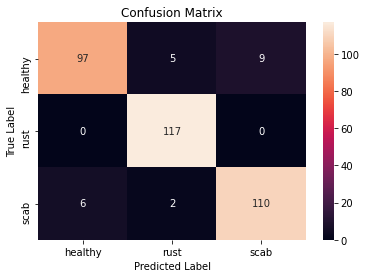

In [15]:
cf_mat = compute_confusion_matrix(y_pred,y,nb_classes)
plot_confusion_matrix(cf_mat)

In [16]:

#функция для получения латентного пространства (модель,генератор и название слоя)

def get_intermediate_layer_output(model,dataset,layer_name= 'avg_pool'):
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    
    intermediate_output = intermediate_layer_model.predict(dataset,verbose=1)
    
    return intermediate_output
    

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

#функция для визуализации латентого пространства

def fit_PCA(x):
    pca_50 = PCA(n_components=50)
    pca = pca_50.fit(x)
    return pca

def transform_PCA(pca,x):
    return pca.transform(x)

def tsne_fit_transform(x):
    tsne = TSNE(n_components=2, verbose=1,n_iter=100000)
    tsne_pca_results = tsne.fit_transform(x)
    return tsne_pca_results
    
def vizualize_latent_space(x,y):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    palette = sns.color_palette("bright", nb_classes)
    plt.title('latent space vizualization')
    y_hue = [category_names[i] for i in y.argmax(axis=1)]
    sns.scatterplot(x[:,0], x[:,1],hue=y_hue, legend='full', palette=palette)

In [41]:
#находим слой пулинга 

layer_name = None

for i in range(len(model.layers)-1,0,-1):
    layer = model.layers[i]
    if 'pool' in layer.name or 'flat' in layer.name:
        layer_name = layer.name
        break

if layer_name is None:
    raise Exception('pooling or flatten layer is not found')
    
inter_out  = get_intermediate_layer_output(model,gen,layer_name)

346/346 [==============================] - 9s 26ms/step


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 346 samples in 0.001s...
[t-SNE] Computed neighbors for 346 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 346 / 346
[t-SNE] Mean sigma: 3.957709
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.329926
[t-SNE] KL divergence after 950 iterations: 0.590057


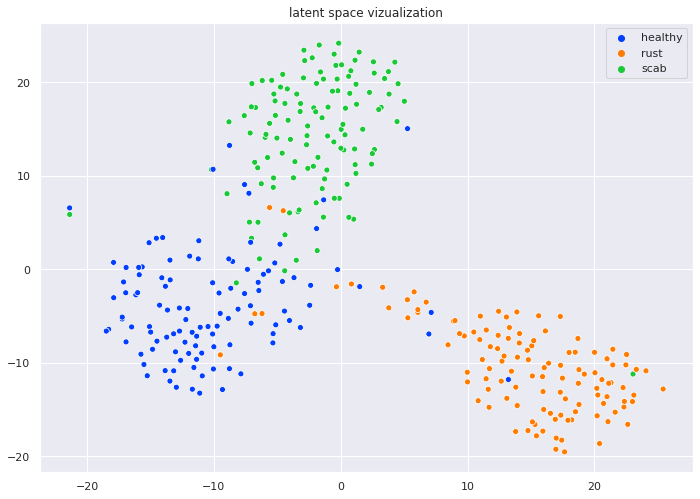

In [37]:
pca = fit_PCA(inter_out)
pca_result = transform_PCA(pca,inter_out)
pca_tsne_result = tsne_fit_transform(pca_result)

vizualize_latent_space(pca_tsne_result,y_pred)